Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train") #path_to_train_directory
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test") #path_to_test_directory

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Train dataset 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation dataset with seed = 123

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

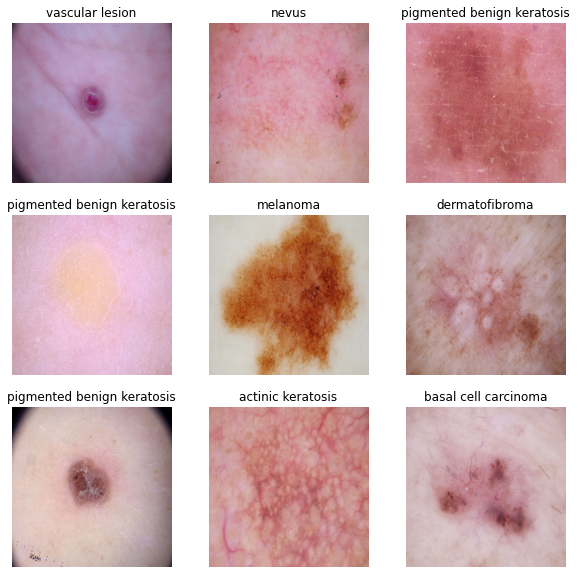

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Normalizing the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [14]:
### Your code goes here
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
# To train the neural network in less time and more efficiently then 'Adam' would be the best optimizer.
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [16]:
num_epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs
)

Epoch 1/20
56/56 [==============================] - 252s 992ms/step - loss: 1.9381 - accuracy: 0.2762 - val_loss: 1.6719 - val_accuracy: 0.4340
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6360 - accuracy: 0.4124 - val_loss: 1.4724 - val_accuracy: 0.5168
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5120 - accuracy: 0.4643 - val_loss: 1.4460 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4317 - accuracy: 0.5011 - val_loss: 1.6735 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3778 - accuracy: 0.5145 - val_loss: 1.3854 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2701 - accuracy: 0.5608 - val_loss: 1.3990 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2067 - accuracy: 0.5765 - val_loss: 1.4452 - val_accuracy: 0.4899
Epoch 8/20

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### Visualizing training results

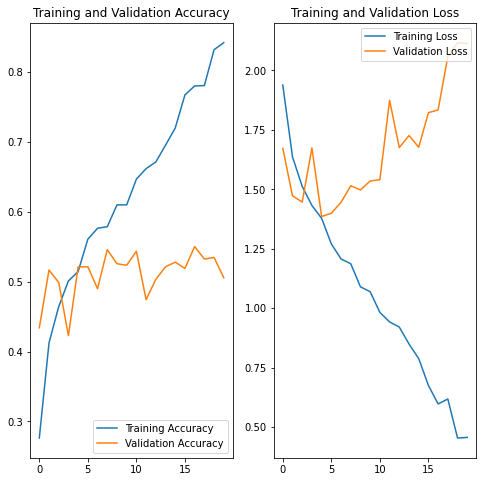

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [19]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [20]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


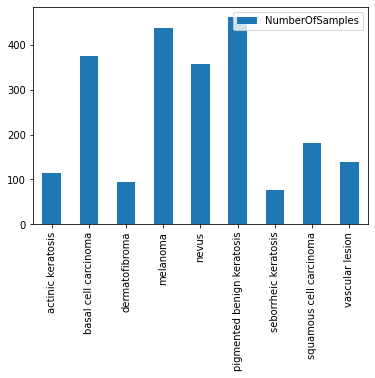

In [21]:
class_df.plot.bar()
plt.show()

### **Rectify the class imbalance**
#### Using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [22]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
path_to_training_dataset= pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC3F639DA90>: 100%|██████████| 500/500 [00:22<00:00, 22.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC460996BD0>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4600CDD10>: 100%|██████████| 500/500 [00:22<00:00, 21.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2198x1603 at 0x7FC46091A410>: 100%|██████████| 500/500 [01:58<00:00,  4.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FC460058E50>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC460A75890>: 100%|██████████| 500/500 [00:22<00:00, 21.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FC46090DF10>: 100%|██████████| 500/500 [00:50<00:00,  9.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC460057D90>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC460AB0B90>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [25]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_8e70c9bc-82d9-438d-8fd8-54884810137b.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_96db70c3-8bd4-4b9c-a74e-37789ed0018a.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_f6df4542-6bda-49c2-9e84-7188d61575f2.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_1df76041-5930-42aa-b200-d76f873bcd62.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic kera

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [27]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [28]:
df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
...,...,...
4495,/content/drive/MyDrive/CNN_assignment/Skin can...,basal cell carcinoma
4496,/content/drive/MyDrive/CNN_assignment/Skin can...,basal cell carcinoma
4497,/content/drive/MyDrive/CNN_assignment/Skin can...,basal cell carcinoma
4498,/content/drive/MyDrive/CNN_assignment/Skin can...,basal cell carcinoma


In [29]:
df['Label'].value_counts()

squamous cell carcinoma       500
pigmented benign keratosis    500
basal cell carcinoma          500
actinic keratosis             500
melanoma                      500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Creating model including normalization

In [34]:
num_classes = len(class_names)

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compiling model with optimizer and loss function 

In [35]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 32)       

#### Train the model

In [37]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 88ms/step - loss: 2.0182 - accuracy: 0.2448 - val_loss: 1.6169 - val_accuracy: 0.4232
Epoch 2/30
169/169 [==============================] - 7s 43ms/step - loss: 1.4682 - accuracy: 0.4479 - val_loss: 1.4256 - val_accuracy: 0.4885
Epoch 3/30
169/169 [==============================] - 7s 43ms/step - loss: 1.2879 - accuracy: 0.5189 - val_loss: 1.2942 - val_accuracy: 0.5019
Epoch 4/30
169/169 [==============================] - 7s 43ms/step - loss: 1.1743 - accuracy: 0.5677 - val_loss: 1.1320 - val_accuracy: 0.6244
Epoch 5/30
169/169 [==============================] - 7s 43ms/step - loss: 1.0674 - accuracy: 0.6055 - val_loss: 1.0524 - val_accuracy: 0.6266
Epoch 6/30
169/169 [==============================] - 7s 43ms/step - loss: 0.9575 - accuracy: 0.6519 - val_loss: 0.9819 - val_accuracy: 0.6548
Epoch 7/30
169/169 [==============================] - 7s 44ms/step - loss: 0.7995 - accuracy: 0.7044 - val_loss: 0.9700 - val_accuracy: 0.651

#### **Todo:**  Visualize the model results

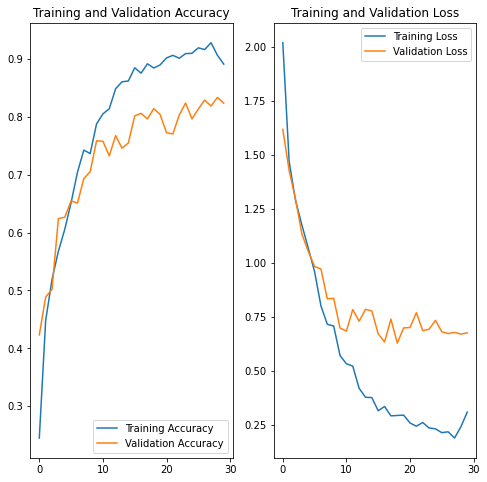

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Model with data augmentation and using Augmentor dataset


In [39]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [40]:
num_classes = len(class_names)

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [41]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)       

In [43]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 9s 47ms/step - loss: 1.9150 - accuracy: 0.2869 - val_loss: 1.5730 - val_accuracy: 0.4313
Epoch 2/50
169/169 [==============================] - 8s 46ms/step - loss: 1.5240 - accuracy: 0.4251 - val_loss: 1.4459 - val_accuracy: 0.4514
Epoch 3/50
169/169 [==============================] - 8s 46ms/step - loss: 1.4335 - accuracy: 0.4551 - val_loss: 1.3078 - val_accuracy: 0.5160
Epoch 4/50
169/169 [==============================] - 8s 46ms/step - loss: 1.3229 - accuracy: 0.5015 - val_loss: 1.3018 - val_accuracy: 0.5189
Epoch 5/50
169/169 [==============================] - 8s 46ms/step - loss: 1.2886 - accuracy: 0.5050 - val_loss: 1.1863 - val_accuracy: 0.5523
Epoch 6/50
169/169 [==============================] - 8s 46ms/step - loss: 1.2377 - accuracy: 0.5261 - val_loss: 1.2195 - val_accuracy: 0.5494
Epoch 7/50
169/169 [==============================] - 8s 46ms/step - loss: 1.1760 - accuracy: 0.5508 - val_loss: 1.1502 - val_accuracy: 0.5791

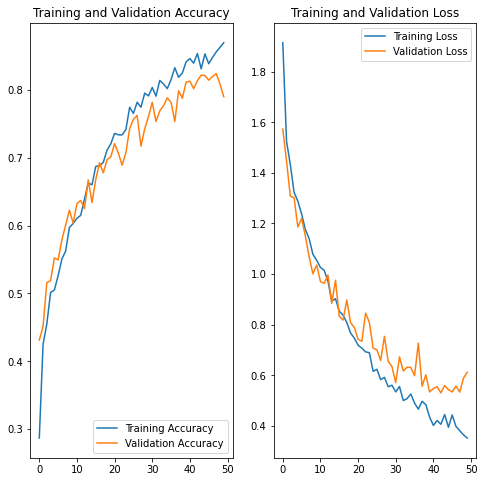

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

###Model evaluation

In [45]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1
 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1
 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1
 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1
 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0]
Labels:
 [0 3 1 0 1 4 3 2 8 5 5 3 1 4 6 7 1 5 3 5 0 0 3 3 2 1 7 4 4 0 7 2]


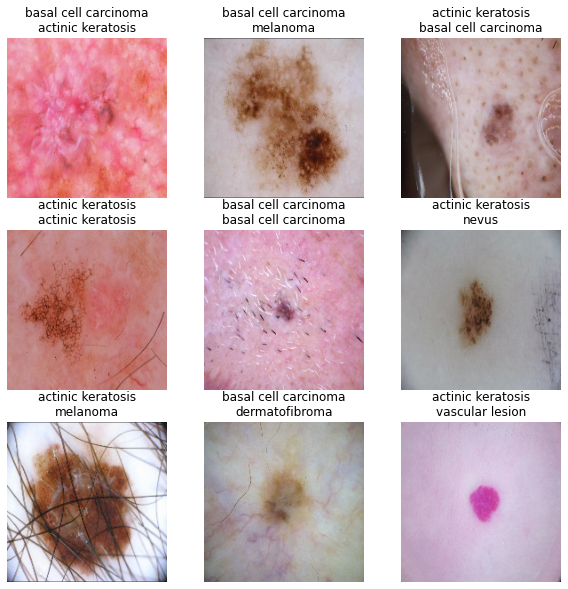

In [46]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")